In [50]:
import operator
from typing import Callable, List

import matplotlib.pyplot as plt
import numpy as np
from fastai.basic_data import DataBunch, DatasetType
from fastai.metrics import accuracy
from fastai.train import Learner
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils as utils
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import pandas as pd

from raw_dataset import RawDataset
from processed_dataset import ProcessedDataset
from split_dataset import SplitDataset
from nn_toolkit.vocab import Vocab, VocabBuilder

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
raw = RawDataset()
processed = ProcessedDataset(raw)
processed.process()
split_ds = SplitDataset(processed)

In [62]:
vocab = VocabBuilder(max_size=20000, min_count=3).from_df(split_ds.train_df, 'tokens')
split_ds.train_df['int_tokens'] = split_ds.train_df.tokens.apply(vocab.map_to_ints)
split_ds.val_df['int_tokens'] = split_ds.val_df.tokens.apply(vocab.map_to_ints)
split_ds.test_df['int_tokens'] = split_ds.test_df.tokens.apply(vocab.map_to_ints)

split_ds.train_df['int_location'] = split_ds.train_df.location_tokens.apply(vocab.map_to_ints)
split_ds.val_df['int_location'] = split_ds.val_df.location_tokens.apply(vocab.map_to_ints)
split_ds.test_df['int_location'] = split_ds.test_df.location_tokens.apply(vocab.map_to_ints)

In [63]:
class SimpleDataset(utils.data.Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        self.maxlen = 128
        self.pad_val = 0
        
    def __getitem__(self, idx: int):
        sample = self.df.iloc[idx]
        tokens = self.get_tokens(sample)
        label = self.get_label(sample)
        return tokens, label
    
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def get_tokens(self, sample: pd.Series) -> torch.LongTensor:
        tokens = sample.int_tokens
        tokens = self._pad_sequence(tokens)
        return torch.LongTensor(tokens)
    
    def get_label(self, sample: pd.Series) -> torch.Tensor:
        return torch.LongTensor([sample.target])
    
    def _pad_sequence(self, seq: List) -> List:
        diff = self.maxlen - len(seq)
        return [self.pad_val]*diff + seq

def collate_simple(batch: List):
    xb = torch.stack([sample[0] for sample in batch])
    yb = torch.cat([sample[1] for sample in batch])
    return xb, yb


def create_simple_databunch(split_ds):
    train_ds = Dataset(split_ds.train_df)
    val_ds = Dataset(split_ds.val_df)
    test_ds = Dataset(split_ds.test_df)

    data = DataBunch.create(train_ds, val_ds, test_ds, collate_fn=collate_simple)
    return data

In [67]:
class MultiDataset(utils.data.Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        self.maxlen = 128
        self.pad_val = 0
        
    def __getitem__(self, idx: int):
        sample = self.df.iloc[idx]
        tokens = self.get_tokens(sample)
        label = self.get_label(sample)
        return tokens, label
    
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def get_tokens(self, sample: pd.Series) -> torch.LongTensor:
        text = sample.int_tokens
        location = sample.int_location
        text = torch.LongTensor(self._pad_sequence(text))
        location = torch.LongTensor(self._pad_sequence(location))
        return {'text': text, 'location': location}
    
    def get_label(self, sample: pd.Series) -> torch.Tensor:
        return torch.LongTensor([sample.target])
    
    def _pad_sequence(self, seq: List) -> List:
        diff = self.maxlen - len(seq)
        return [self.pad_val]*diff + seq

def collate_multi(batch: List):
    text = torch.stack([sample[0]['text'] for sample in batch])
    location = torch.stack([sample[0]['location'] for sample in batch])
    xb = {'text': text, 'location': location}
    yb = torch.cat([sample[1] for sample in batch])
    return xb, yb

def create_multi_databunch(split_ds):
    train_ds = MultiDataset(split_ds.train_df)
    val_ds = MultiDataset(split_ds.val_df)
    test_ds = MultiDataset(split_ds.test_df)

    data = DataBunch.create(train_ds, val_ds, test_ds, collate_fn=collate_multi)
    return data

In [68]:
simple_data = create_simple_databunch(split_ds)
multi_data = create_multi_databunch(split_ds)
simple_data.one_batch()

(tensor([[   0,    0,    0,  ...,   17,   19,    3],
         [   0,    0,    0,  ...,  539,  265,    3],
         [   0,    0,    0,  ...,   17,   19,    3],
         ...,
         [   0,    0,    0,  ..., 1278,  328,    3],
         [   0,    0,    0,  ...,    1,  139,    3],
         [   0,    0,    0,  ...,    1,    1,    3]]),
 tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
         0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]))

In [69]:
multi_data.one_batch()

({'text': tensor([[   0,    0,    0,  ...,   17,   19,    3],
          [   0,    0,    0,  ...,   17,   19,    3],
          [   0,    0,    0,  ...,    1,  139,    3],
          ...,
          [   0,    0,    0,  ...,  768,  139,    3],
          [   0,    0,    0,  ...,   17,   19,    3],
          [   0,    0,    0,  ..., 2957,   14,    3]]),
  'location': tensor([[0, 0, 0,  ..., 2, 1, 3],
          [0, 0, 0,  ..., 2, 1, 3],
          [0, 0, 0,  ..., 1, 1, 3],
          ...,
          [0, 0, 0,  ..., 2, 1, 3],
          [0, 0, 0,  ..., 0, 2, 3],
          [0, 0, 0,  ..., 0, 2, 3]])},
 tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]))

In [76]:
class Encoder(nn.Module):
    def __init__(self, vocab: Vocab, hidden_size: int, num_layers: int) -> None:
        super().__init__()
        self.embedding_layer = nn.Embedding(
            vocab.size,
            hidden_size,
            padding_idx=0
        )
        self.rnn= nn.LSTM(
            hidden_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
    
    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.embedding_layer(X)
        emb, state = self.rnn(emb)
        return emb

class SimpleClassifier(nn.Module):
    def __init__(self, vocab: Vocab, hidden_size: int, num_layers: int) -> None:
        super().__init__()
        self.encoder = Encoder(vocab, hidden_size, num_layers)
        self.densor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)
        )
    
    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.encoder(X)
        emb = emb[:, -1]
        logit = self.densor(emb)
        log_prob = F.log_softmax(logit, dim=-1)
        return log_prob

    
class MultiClassifier(nn.Module):
    def __init__(self, vocab: Vocab, hidden_size: int, num_layers: int) -> None:
        super().__init__()
        self.encoder = Encoder(vocab, hidden_size, num_layers)
        self.merge_layer = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.Tanh()
        )
        self.densor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)
        )

    def forward(self, X: dict) -> torch.FloatTensor:
        text = X['text']
        location = X['location']
        t_emb = self.text_encoder(text)
        l_emb = self.loc_encoder(location)
        last_t = t_emb[:, -1]
        last_l = t_emb[:, -1]
        emb = torch.cat([last_t, last_l], dim=-1)
        emb = self.merge_layer(emb)
        logit = self.densor(emb)
        log_prob = F.log_softmax(logit, dim=-1)
        return log_prob

In [71]:
_HIDDEN_SIZE = 128
_NUM_LAYERS = 2

In [72]:
model = SimpleClassifier(vocab, _HIDDEN_SIZE, _NUM_LAYERS)
learner = Learner(data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])

epoch     train_loss  valid_loss  accuracy  time    
0         9.206878    #na#        00:36     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<IPython.core.display.Javascript object>


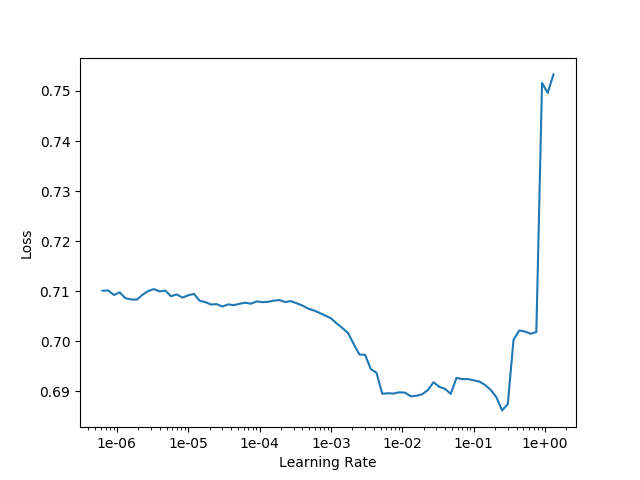

/home/mayen/anaconda3/envs/kaggle/lib/python3.7/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


In [45]:
learner.lr_find()
learner.recorder.plot()

In [46]:
learner.fit_one_cycle(2, max_lr=1e-2)
learner.fit(15, 1e-3)

epoch     train_loss  valid_loss  accuracy  time    
0         0.617153    0.543464    0.731451  00:40     
1         0.476428    0.493306    0.778726  00:40     


In [77]:
model = MultiClassifier(vocab, _HIDDEN_SIZE, _NUM_LAYERS)
learner = Learner(multi_data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch     train_loss  valid_loss  accuracy  time    


In [52]:
learner.fit_one_cycle(2, max_lr=1e-2)
learner.fit(15, 1e-3)

,id,keyword,location,text,target,tokens,int_tokens
4148,5896,harm,?semekeepschanging@soyeh?,PEOPLE KEEP NOT TAGGING SELF HARM AND IT'S FUC...,0,"[people, keep, not, tagging, self, harm, and, ...","[2, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13, 14, 3]"
4565,6491,injuries,come here in 20 minutes for an ass kicking,in fact if y'all could tag like small creeping...,0,"[in, fact, if, y'all, could, tag, like, small,...","[2, 15, 16, 17, 18, 19, 20, 21, 22, 1, 23, 7, ..."
5532,7891,quarantined,"Poplar, London",can't DL a patch to fix the error in symantec ...,0,"[ca, n't, dl, a, patch, to, fix, the, error, i...","[2, 36, 37, 1, 38, 39, 40, 41, 26, 42, 15, 1, ..."
286,419,apocalypse,NaN,RT: Our_Mother_Mary: Short Reading\n\nApocalyp...,0,"[rt, :, our_mother_mary, :, short, reading, ap...","[2, 52, 53, 1, 53, 54, 55, 56, 1, 15, 26, 57, ..."
3687,5247,fatality,USA,Kosciusko police investigating pedestrian fata...,0,"[kosciusko, police, investigating, pedestrian,...","[2, 1, 66, 67, 1, 68, 69, 70, 38, 71, 72, 73, ..."
...,...,...,...,...,...,...,...
7004,10041,twister,"Lisbon, Portugal",@ElianaRaquel Like GG was BAD in the end... Bu...,0,"[@, elianaraquel, like, gg, was, bad, in, the,...","[2, 75, 1, 21, 1, 276, 980, 15, 26, 1523, 64, ..."
5033,7176,mudslide,London,First impressions: glad hat man is leaving in ...,0,"[first, impressions, :, glad, hat, man, is, le...","[2, 491, 1, 53, 808, 1244, 394, 191, 3235, 15,..."
4970,7086,meltdown,Two Up Two Down,@LeMaireLee @danharmon People Near Meltdown Co...,0,"[@, lemairelee, @, danharmon, people, near, me...","[2, 75, 1, 75, 1, 4, 271, 2836, 1, 105, 185, 8..."
1027,1491,body%20bags,"LONG ISLAND, NY",BODY BAGS! https://t.co/0McXc68GZD,0,"[body, bags, !, https, :, //t.co]","[2, 436, 1822, 298, 143, 53, 74, 3]"
